<a href="https://colab.research.google.com/github/BharathSShankar/DSA4212_Assignments/blob/bharath-exp/BayesianNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist torchmetrics
!python -m medmnist download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/tissuemnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organcmnist.npz
Using downloaded and verified file: /root/.medmnist/organsmnist.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and 

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cd "/content/drive/MyDrive/DSA4212/Assignment 3"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import medmnist
from medmnist import INFO, Evaluator

In [5]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PI = 0.5
SIGMA_1 = torch.FloatTensor([np.exp(1)]).to(DEVICE)
SIGMA_2 = torch.FloatTensor([np.exp(-4)]).to(DEVICE)

In [8]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-np.log(np.sqrt(2 * np.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [9]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [10]:
class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.1, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-7,-5))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.1, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-7,-5))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)
    
    def kl_loss(self):
        kl = self.weight_prior.log_prob(self.weight.mu) - self.weight.log_prob(self.weight.mu)
        kl += self.bias_prior.log_prob(self.bias.mu) - self.bias.log_prob(self.bias.mu)
        return kl.sum()

In [11]:
class BayesianConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, k_size):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_size = k_size

        self.weight_mu = nn.Parameter(torch.Tensor(out_channels, in_channels, k_size, k_size).uniform_(-0.1, 0.1))
        self.weight_rho = nn.Parameter(torch.Tensor(out_channels, in_channels, k_size,k_size).uniform_(-7,-5))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)

        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).uniform_(-0.1, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels).uniform_(-7,-5))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)

        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.conv2d(input, weight, bias)
    
    def kl_loss(self):
        kl = self.weight_prior.log_prob(self.weight.mu) - self.weight.log_prob(self.weight.mu)
        kl += self.bias_prior.log_prob(self.bias.mu) - self.bias.log_prob(self.bias.mu)
        return kl.sum()

In [12]:
class BayesianNeuralNetFC(nn.Module):
    def __init__(self, layers_dims, input_size, n_classes):
        super().__init__()
        self.inputLayer = BayesianDense(input_size, layers_dims[0])
        layer_list = []
        for i in range(1, len(layers_dims)):
            layer_list.append(BayesianDense(layers_dims[i - 1], layers_dims[i]))
        self.linears = nn.ModuleList(layer_list)
        self.outputLayer = BayesianDense(layers_dims[-1], n_classes)
    
    def forward(self, input, sample=False, calculate_log_probs=False):
        x = nn.Flatten()(input)
        x = self.inputLayer(x, sample, calculate_log_probs)
        x = F.relu(x)
        x = nn.Dropout(p=0.1)(x)
        for layer in self.linears:
            x = layer(x, sample, calculate_log_probs)
            x = F.relu(x)
            x = nn.Dropout(p=0.1)(x)
        x = self.outputLayer(x)
        return x

    def kl_loss(self):
        kl = 0.0
        for layer in self.linears:
            kl += layer.kl_loss()
        kl += self.inputLayer.kl_loss()
        kl += self.outputLayer.kl_loss()
        return kl

In [13]:
def train_bayesian_net(net, train_loader, test_loader, is_bayes=False, n_epochs=20, lr=3e-4, log_interval=10, beta=1e-7):
    # Define loss function and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Move model to device
    net.to(DEVICE)

    # Training loop
    for epoch in range(n_epochs):
        # Training mode
        net.train()
        train_loss = 0
        ce_loss = 0
        kl_loss = 0
        correct = 0
        total = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}") as t:
            for batch_idx, (data, target) in enumerate(t):
                data, target = data.to(DEVICE), target.to(DEVICE)

                # Forward pass
                optimizer.zero_grad()
                outputs = net(data)

                # Compute loss and update model
                if is_bayes:
                    ce_loss = loss_func(outputs, target.T[0])
                    kl_loss = net.kl_loss()
                    loss = ce_loss - beta * kl_loss
                else:
                    loss = loss_func(outputs, target.T[0])

                loss.backward()
                optimizer.step()

                # Update training statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += data.shape[0]
                correct += predicted.eq(target.T[0]).sum().item()

                # Log training progress
                if batch_idx % log_interval == 0:
                    train_acc = correct / total
                    train_loss /= log_interval
                    ce_loss /= log_interval
                    kl_loss /= log_interval
                    t.set_postfix(ce_loss=f"{ce_loss:.6f}", kl_loss=f"{kl_loss:.6f}", loss=f"{train_loss:.6f}", accuracy=f"{train_acc:.2f}")
                    train_loss = 0
                    ce_loss = 0
                    kl_loss = 0
                    correct = 0
                    total = 0

        # Evaluation mode
        net.eval()
        test_loss = 0
        ce_loss = 0
        kl_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)

                # Forward pass
                outputs = net(data)

                # Compute loss and update evaluation statistics
                if is_bayes:
                    ce_loss = loss_func(outputs, target.T[0])
                    kl_loss = net.kl_loss()
                    loss = ce_loss - beta * kl_loss
                else:
                    loss = loss_func(outputs, target.T[0])

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += data.shape[0]
                correct += predicted.eq(target.T[0]).sum().item()

        # Log evaluation statistics
        test_acc = 100. * correct / total
        test_loss /= len(test_loader)
        if is_bayes:
            print('Test set: Average loss: {:.4f}, CE loss: {:.4f}, KL loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
                test_loss, ce_loss, kl_loss, test_acc))
        else:
            print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
                test_loss,test_acc))

In [14]:
net = BayesianNeuralNetFC([128, 256, 64], 3 * 28 * 28, 9)
train_bayesian_net(net, train_loader, test_loader, is_bayes = True)

Epoch 1: 100%|██████████| 704/704 [00:48<00:00, 14.40it/s, accuracy=0.53, ce_loss=0.129356, kl_loss=-188970.890625, loss=1.480637]


Test set: Average loss: 1.4771, CE loss: 1.2483, KL loss: -1889416.8750, Accuracy: 51.87%



Epoch 2: 100%|██████████| 704/704 [00:41<00:00, 16.97it/s, accuracy=0.56, ce_loss=0.124148, kl_loss=-184766.984375, loss=1.404949]


Test set: Average loss: 1.4750, CE loss: 1.6132, KL loss: -1847497.6250, Accuracy: 53.33%



Epoch 3: 100%|██████████| 704/704 [00:41<00:00, 17.07it/s, accuracy=0.59, ce_loss=0.101619, kl_loss=-181781.109375, loss=1.280023]


Test set: Average loss: 1.3380, CE loss: 1.2371, KL loss: -1817712.0000, Accuracy: 58.59%



Epoch 4: 100%|██████████| 704/704 [00:40<00:00, 17.40it/s, accuracy=0.55, ce_loss=0.112752, kl_loss=-179375.312500, loss=1.321656]


Test set: Average loss: 1.3018, CE loss: 1.3866, KL loss: -1793636.8750, Accuracy: 59.86%



Epoch 5: 100%|██████████| 704/704 [00:41<00:00, 16.87it/s, accuracy=0.59, ce_loss=0.106818, kl_loss=-177435.093750, loss=1.253094]


Test set: Average loss: 1.2826, CE loss: 1.2040, KL loss: -1774230.3750, Accuracy: 60.50%



Epoch 6: 100%|██████████| 704/704 [00:40<00:00, 17.38it/s, accuracy=0.60, ce_loss=0.099690, kl_loss=-175801.984375, loss=1.221104]


Test set: Average loss: 1.2789, CE loss: 1.5461, KL loss: -1757935.2500, Accuracy: 60.24%



Epoch 7: 100%|██████████| 704/704 [00:40<00:00, 17.33it/s, accuracy=0.61, ce_loss=0.114256, kl_loss=-174423.937500, loss=1.204934]


Test set: Average loss: 1.3566, CE loss: 1.6455, KL loss: -1744129.0000, Accuracy: 59.64%



Epoch 8: 100%|██████████| 704/704 [00:40<00:00, 17.25it/s, accuracy=0.61, ce_loss=0.111377, kl_loss=-173208.718750, loss=1.175163]


Test set: Average loss: 1.2538, CE loss: 1.4717, KL loss: -1732018.0000, Accuracy: 61.91%



Epoch 9: 100%|██████████| 704/704 [00:40<00:00, 17.24it/s, accuracy=0.65, ce_loss=0.087488, kl_loss=-172194.156250, loss=1.120324]


Test set: Average loss: 1.2232, CE loss: 1.3799, KL loss: -1721854.7500, Accuracy: 63.11%



Epoch 10: 100%|██████████| 704/704 [00:41<00:00, 17.14it/s, accuracy=0.63, ce_loss=0.100605, kl_loss=-171240.015625, loss=1.160087]


Test set: Average loss: 1.3220, CE loss: 1.7877, KL loss: -1712384.6250, Accuracy: 60.26%



Epoch 11: 100%|██████████| 704/704 [00:40<00:00, 17.32it/s, accuracy=0.63, ce_loss=0.091142, kl_loss=-170468.718750, loss=1.114661]


Test set: Average loss: 1.2742, CE loss: 1.3786, KL loss: -1704623.7500, Accuracy: 62.48%



Epoch 12: 100%|██████████| 704/704 [00:41<00:00, 17.09it/s, accuracy=0.63, ce_loss=0.085387, kl_loss=-169783.921875, loss=1.107641]


Test set: Average loss: 1.2481, CE loss: 1.5566, KL loss: -1697785.6250, Accuracy: 63.27%



Epoch 13: 100%|██████████| 704/704 [00:40<00:00, 17.49it/s, accuracy=0.67, ce_loss=0.103099, kl_loss=-169154.109375, loss=1.057533]


Test set: Average loss: 1.2506, CE loss: 1.2987, KL loss: -1691516.7500, Accuracy: 63.62%



Epoch 14: 100%|██████████| 704/704 [00:41<00:00, 17.06it/s, accuracy=0.67, ce_loss=0.091058, kl_loss=-168592.140625, loss=1.093756]


Test set: Average loss: 1.2911, CE loss: 1.7496, KL loss: -1685872.3750, Accuracy: 62.42%



Epoch 15: 100%|██████████| 704/704 [00:40<00:00, 17.51it/s, accuracy=0.66, ce_loss=0.080437, kl_loss=-168093.640625, loss=1.057264]


Test set: Average loss: 1.1691, CE loss: 1.1408, KL loss: -1680939.7500, Accuracy: 64.89%



Epoch 16: 100%|██████████| 704/704 [00:41<00:00, 17.11it/s, accuracy=0.67, ce_loss=0.083163, kl_loss=-167582.640625, loss=1.041369]


Test set: Average loss: 1.2410, CE loss: 1.4396, KL loss: -1675741.2500, Accuracy: 63.87%



Epoch 17: 100%|██████████| 704/704 [00:40<00:00, 17.25it/s, accuracy=0.65, ce_loss=0.102743, kl_loss=-167178.484375, loss=1.068235]


Test set: Average loss: 1.2371, CE loss: 1.4625, KL loss: -1671748.7500, Accuracy: 62.81%



Epoch 18: 100%|██████████| 704/704 [00:41<00:00, 17.16it/s, accuracy=0.68, ce_loss=0.086880, kl_loss=-166784.843750, loss=0.994299]


Test set: Average loss: 1.2017, CE loss: 1.2057, KL loss: -1667814.1250, Accuracy: 64.67%



Epoch 19: 100%|██████████| 704/704 [00:41<00:00, 16.93it/s, accuracy=0.68, ce_loss=0.076546, kl_loss=-166444.437500, loss=1.007481]


Test set: Average loss: 1.3614, CE loss: 1.6822, KL loss: -1664413.1250, Accuracy: 62.63%



Epoch 20: 100%|██████████| 704/704 [00:40<00:00, 17.22it/s, accuracy=0.69, ce_loss=0.082736, kl_loss=-166109.625000, loss=0.981003]


Test set: Average loss: 1.2747, CE loss: 1.7851, KL loss: -1661102.6250, Accuracy: 62.87%



In [15]:
net= nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.LazyLinear(9),
    nn.Softmax(dim = 1)
).to(DEVICE)
train_bayesian_net(net, train_loader, test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epoch 1: 100%|██████████| 704/704 [00:24<00:00, 28.65it/s, accuracy=0.46, ce_loss=0.000000, kl_loss=0.000000, loss=1.904436]


Test set: Average loss: 1.8076, Accuracy: 56.2535


Epoch 2: 100%|██████████| 704/704 [00:24<00:00, 28.68it/s, accuracy=0.47, ce_loss=0.000000, kl_loss=0.000000, loss=1.899355]


Test set: Average loss: 1.7466, Accuracy: 62.0195


Epoch 3: 100%|██████████| 704/704 [00:24<00:00, 29.10it/s, accuracy=0.50, ce_loss=0.000000, kl_loss=0.000000, loss=1.870699]


Test set: Average loss: 1.7356, Accuracy: 62.9666


Epoch 4:  49%|████▊     | 342/704 [00:11<00:12, 29.22it/s, accuracy=0.49, ce_loss=0.000000, kl_loss=0.000000, loss=1.876092]


KeyboardInterrupt: ignored

In [16]:
class BayesianNeuralNetConv(nn.Module):
    def __init__(self, channel_list, input_channels, n_classes):
        super().__init__()
        self.inputLayer = BayesianConv2D(input_channels, channel_list[0], k_size=3)
        layer_list = []
        for i in range(1, len(channel_list)):
            layer_list.append(BayesianConv2D(channel_list[i - 1], channel_list[i], k_size=1))
        self.convs = nn.ModuleList(layer_list)
        self.fc = BayesianDense(channel_list[-1] * 9, n_classes)
    
    def forward(self, input, sample=False, calculate_log_probs=False):
        x = self.inputLayer(input, sample, calculate_log_probs)
        x = F.rrelu(x)
        x = F.max_pool2d(x, 2)
        for conv in self.convs:
            x = conv(x, sample, calculate_log_probs)
            x = F.rrelu(x)
            x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.fc(x, sample, calculate_log_probs)
        return x
    
    def kl_loss(self):
        kl = 0.0
        for layer in self.convs:
            kl += layer.kl_loss()
        kl += self.inputLayer.kl_loss()
        kl += self.fc.kl_loss()
        return kl


In [17]:
net = BayesianNeuralNetConv([128, 256, 512], 3, 9)
train_bayesian_net(net, train_loader, test_loader, is_bayes = True)

Epoch 1: 100%|██████████| 704/704 [00:53<00:00, 13.24it/s, accuracy=0.71, ce_loss=0.075787, kl_loss=-117351.773438, loss=0.893424]


Test set: Average loss: 1.0661, CE loss: 0.6341, KL loss: -1173445.8750, Accuracy: 73.41%



Epoch 2:  11%|█▏        | 80/704 [00:06<00:48, 12.89it/s, accuracy=0.75, ce_loss=0.069641, kl_loss=-117239.335938, loss=0.832357]


KeyboardInterrupt: ignored

In [18]:
def get_prediction_probabilities(model, test_loader, n=10):
    model.eval()
    logits = torch.zeros((n, len(test_loader.dataset), model.fc.out_features))
    labels = torch.zeros((len(test_loader.dataset)))
    with torch.no_grad():
        for i in range(n):
            for j, (inputs, targets) in enumerate(test_loader):
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                outputs = model(inputs, True, True)
                logits[i, j*test_loader.batch_size:(j+1)*test_loader.batch_size] = outputs
                labels[j*test_loader.batch_size:(j+1)*test_loader.batch_size] = targets.T[0]
    probabilities = torch.softmax(logits, dim=-1)
    mean_probs = torch.mean(probabilities, dim=0)
    predictive_entropy = -torch.sum(mean_probs * torch.log(mean_probs), dim=-1)
    return logits, probabilities, predictive_entropy, labels

logits, probabilities, predictive_entropy, labels = get_prediction_probabilities(net, test_loader, 10)

In [19]:
print(logits[:, 1])

tensor([[-0.6037, -3.5863, -1.9224, -1.6959,  2.8559, -2.3990,  1.7604, -0.4367,
         -1.2210],
        [-0.8107, -3.3426, -2.0961, -1.3493,  2.6997, -2.6906,  1.7780, -0.5575,
         -0.9896],
        [-0.8343, -3.3005, -2.1825, -1.4862,  2.7881, -2.7722,  1.7660, -0.8172,
         -0.9417],
        [-0.8948, -3.3657, -2.0796, -1.4006,  2.7566, -2.7736,  1.8590, -0.7096,
         -0.7675],
        [-1.1287, -3.9814, -1.4084, -1.9494,  2.6524, -1.9985,  1.7404, -0.1686,
         -1.0215],
        [-0.7155, -3.5626, -2.1279, -1.3275,  2.7014, -2.4749,  1.8706, -0.4577,
         -1.1350],
        [-1.1964, -3.8669, -1.8319, -1.6592,  2.4395, -2.2342,  1.7768, -0.1696,
         -0.9800],
        [-0.8075, -3.4463, -1.8432, -2.2803,  2.7256, -2.3143,  1.7744, -0.2795,
         -1.1695],
        [-1.0160, -3.0700, -1.9822, -2.1651,  2.7487, -2.5223,  1.7361, -0.6183,
         -0.9202],
        [-0.8066, -3.5681, -1.8636, -1.6467,  2.6406, -2.5426,  1.8008, -0.4408,
         -1.1334]])

In [20]:
print(probabilities[:, 1])

tensor([[0.0217, 0.0011, 0.0058, 0.0073, 0.6917, 0.0036, 0.2313, 0.0257, 0.0117],
        [0.0196, 0.0016, 0.0054, 0.0114, 0.6562, 0.0030, 0.2611, 0.0253, 0.0164],
        [0.0182, 0.0015, 0.0047, 0.0095, 0.6827, 0.0026, 0.2457, 0.0186, 0.0164],
        [0.0170, 0.0014, 0.0052, 0.0103, 0.6562, 0.0026, 0.2674, 0.0205, 0.0193],
        [0.0147, 0.0008, 0.0111, 0.0065, 0.6462, 0.0062, 0.2596, 0.0385, 0.0164],
        [0.0210, 0.0012, 0.0051, 0.0114, 0.6386, 0.0036, 0.2782, 0.0271, 0.0138],
        [0.0156, 0.0011, 0.0083, 0.0098, 0.5918, 0.0055, 0.3050, 0.0436, 0.0194],
        [0.0193, 0.0014, 0.0069, 0.0044, 0.6618, 0.0043, 0.2557, 0.0328, 0.0135],
        [0.0158, 0.0020, 0.0060, 0.0050, 0.6799, 0.0035, 0.2470, 0.0235, 0.0173],
        [0.0203, 0.0013, 0.0071, 0.0088, 0.6390, 0.0036, 0.2759, 0.0293, 0.0147]])


In [21]:
print(labels[1])

tensor(4.)


In [22]:
import matplotlib.pyplot as plt

def display_image_with_probabilities(image, probabilities):
    """
    Displays an RGB image in the left pane and shows the calculated probabilities on the right pane.

    Args:
    - image: A PyTorch tensor representing the RGB image.
    - probabilities: A PyTorch tensor representing the predicted probabilities.

    Returns: None
    """
    image = image.detach().cpu().numpy()

    # Convert the probabilities tensor to a NumPy array
    probabilities = probabilities.detach().cpu().numpy()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    # Display the image in the left subplot
    ax1.imshow(image.transpose(1,2,0))

    # Set the title of the left subplot
    ax1.set_title('Image')

    # Create a bar chart of the probabilities in the right subplot
    ax2.barh(range(probabilities.shape[1]), probabilities.squeeze())

    # Set the y-axis tick labels to the class names
    ax2.set_yticks(range(probabilities.shape[1]))
    ax2.set_yticklabels(range(probabilities.shape[1]))

    # Set the title of the right subplot
    ax2.set_title('Predicted Probabilities')

    # Show the plot
    plt.show()


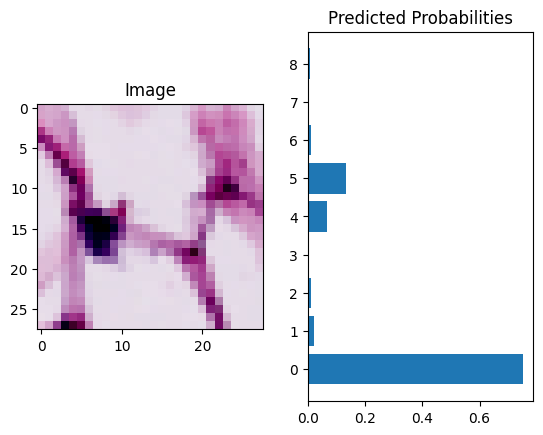

tensor([0])


In [26]:
images, labels = next(iter(test_loader))
index = np.random.randint(0, 127)
image = images[index]
label = labels[index]
logits = net(image.unsqueeze(0).to(DEVICE))
probabilities = torch.softmax(logits, dim=1)
display_image_with_probabilities(image, probabilities)
print(label)

In [24]:
import torch

import torchmetrics

# Define the device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the batch size for the DataLoader
targets = []
probs = []

for images, labels in tqdm(test_loader):
    # Move the data to the device
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Get the predicted probabilities from the model
    logits = net(images)
    probabilities = torch.softmax(logits, dim=1)

    # Append the targets and predicted probabilities to the lists
    targets.append(labels.detach())
    probs.append(probabilities.detach())

# Concatenate the targets and predicted probabilities
targets = torch.nn.functional.one_hot(torch.cat(targets).squeeze())
probs = torch.cat(probs)

# Calculate the ECE
ece = torchmetrics.functional.classification.binary_calibration_error(probs, targets, 9)



100%|██████████| 29/29 [00:01<00:00, 17.36it/s]

torch.Size([])


In [25]:
print(ece)

tensor(0.0095, device='cuda:0')
